<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S06_Time-Series_Analytics/S06B_Simple_TS_using_statsforecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S06 Simple time-series forecast and evaluation using `statsforecast`

### Introduction

Time series demand forecasting is crucial for effective supply chain management. With accurate demand forecasts, businesses can optimize inventory, improve demand planning, enhance sales forecasting, and mitigate supply chain risks.

With recent development in Python and opensources, there are many simple-to-use packages such as [statsmodels](https://www.statsmodels.org/stable/index.html) (mainly for statistical techniques), [Prophet (by Facebook)](https://facebook.github.io/prophet/), [GluonTS (by Amazon)] (https://ts.gluon.ai/stable/), and many other libraries. Most libraries require a specific (but similar) data input format and processes. Thus, the most important step to use such packages is to prepare the data in the right format.

There are also opensource libaries that are built upon many time-series forecasting packages and provide interfaces to many time-series algorithms such as [sktime](https://www.sktime.net/en/latest/index.html), [darts](https://unit8co.github.io/darts/) and [statsforecast](https://nixtlaverse.nixtla.io/statsforecast/index.html). These time-series forecasting interfaces greatly simplify forecasting with its intuitive API and diverse range of models, including classical statistical methods and modern machine learning approaches including deep-learning-based models.

In this notebook, we will provide a simple walkthrough to the time-series analysis using `statsforecast`. There is also a demo that provides more comprehensive pipelines of the forecasting processes.

First of all, an installation of `statsforecast` is mandatory since it is not included in Colab by default.

In [ ]:
!pip install statsforecast


### **Step 1**: Load data

 **IMPORTANT**: The index of the Series or DataFrame prior to conversion must be in `datetime` format (i.e., using the function `pd.to_datetime(...)`). Note that `statsforecast` always require three specific columns, i.e., (1) `ds` (date in `datetime` format), (2) `y` (value) and (3) `unique_id` (name of the series or item to forecast)

In [2]:
# simple Python code for time-series using sktime
import pandas as pd
import numpy as np

data = pd.read_csv('https://bit.ly/m5simple')

# Since statsforecast supports multi-variate time-series by default, we need to prepare three columns as follows

# First, the column 'ds' must be in datetime format
data['ds'] = pd.to_datetime(data['ds'])

# Second, the column 'y' must be in float
data['y'] = data['y'].astype(np.float64)

# Third, we need to create another column that indicate the name of the item or series (this is required by the package)
data['unique_id'] = len(data)*['item 1']
data['unique_id'] = data['unique_id'].astype('string')

y_timeseries = data
y_timeseries

,ds,y,unique_id
0,2013-01-06,1970.0,item 1
1,2013-01-13,2057.0,item 1
2,2013-01-20,1980.0,item 1
3,2013-01-27,2869.0,item 1
4,2013-02-03,3441.0,item 1
...,...,...,...
172,2016-04-24,3721.0,item 1
173,2016-05-01,3802.0,item 1
174,2016-05-08,3890.0,item 1
175,2016-05-15,4212.0,item 1


### **Step 2**: Train/test split

We then split the time-series data into the training set and test set. The test set contains the last 52 data points whereas the training set contains all the data from the beginning until the period preceeding the test set.

In [3]:
test_n_points = 52

train = y_timeseries[:-test_n_points] # train set is the time series without the last test_n_points = 52 points
test = y_timeseries[-test_n_points:] # last test_n_points = 52 is part of the test set

### **Step 3**: Train the model

Similar to `sklearn`, we can simply create a model object and fit the data to the model. In the following block, we provide examples of different time-series models. `Statsforecast` works a bit differently than `darts` as it requires giving a list of forecasting models to the core method named `StatsForecast(models = list_models , freq = 'W')` where `list_models` indicates the forecasting models to fit and we indicate the length of period in `freq`, e.g., daily `D`, weekly `W`, or monthly `M`. Here the data is weekly so `freq = 'W'`.

Then the function `.fit(...)` is used to fit the data to the model (training).

The list of the models supported by `statsforecast` is available here: [statsforecast forecasting models](https://nixtlaverse.nixtla.io/statsforecast/src/core/models_intro). The nice thing about `statsforecast` is that there are multiple models with the name `Auto` that will automate the parameter optimization so that they don't require any input parameters to run.

In [4]:
from statsforecast import StatsForecast
from statsforecast.models import HoltWinters, CrostonOptimized, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta, MSTL

model_list = [HoltWinters(season_length = 52), CrostonOptimized(), SeasonalNaive(season_length = 52), \
              AutoARIMA(),  AutoETS(season_length = 52), AutoTheta(), MSTL(season_length = 52)]

sf = StatsForecast(models=model_list, freq='W')

sf.fit(train)


StatsForecast(models=[HoltWinters,CrostonOptimized,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,MSTL])

### **Step 4**: Create predictions for the period of the test set.

We can then generate the prediction of the following 52 periods, which corresponds to the period in the test set in order to measure the quality of the forecasts on an out-of-sample basis (using test data that has not been included in the training set). We can also convert the output into series (by using `.pd_series()`) or dataframe (by using `.pd_dataframe()`).

In [5]:
forecast = sf.predict(h=test_n_points)
forecast


,unique_id,ds,HoltWinters,CrostonOptimized,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,MSTL
0,item 1,2015-05-31,3928.126567,3835.504972,3513.0,3837.060083,3663.182400,3735.805713,4085.107723
1,item 1,2015-06-07,4183.801798,3835.504972,3406.0,3837.060083,3663.267640,3740.693871,4174.358402
2,item 1,2015-06-14,3786.428401,3835.504972,3133.0,3837.060083,3663.335838,3745.582029,3813.990154
3,item 1,2015-06-21,3859.810041,3835.504972,3394.0,3837.060083,3663.390402,3750.470186,3964.804221
4,item 1,2015-06-28,3617.419806,3835.504972,3477.0,3837.060083,3663.434057,3755.358344,3869.336176
5,item 1,2015-07-05,3787.474361,3835.504972,3680.0,3837.060083,3663.468984,3760.246502,4055.265790
6,item 1,2015-07-12,3569.976901,3835.504972,3187.0,3837.060083,3663.496928,3765.134659,3698.176652
7,item 1,2015-07-19,3809.537620,3835.504972,3439.0,3837.060083,3663.519285,3770.022817,3943.861230
8,item 1,2015-07-26,3277.555126,3835.504972,3107.0,3837.060083,3663.537172,3774.910975,3507.535756
9,item 1,2015-08-02,3944.075431,3835.504972,3823.0,3837.060083,3663.551484,3779.799132,4186.251101


### **Step 5**: Measure the forecasting errors.

We measure the results using four different error measures, i.e., Mean Absolute Percentage Error (MAPE) using the function from `sklearn`, Symmetric Mean Absolute Percentage Error (sMAPE) using list comprehension, Root Mean Squared Error (RMSE) using the function from `sklearn`, and Mean Error (ME) using using list comprehension.

In [6]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

for model in model_list:
  model_name = str(model)
  print("Model[",model_name,"]:")
  m_mape = mean_absolute_percentage_error(test['y'], forecast[model_name])

  m_smape = sum([abs(x_test - x_forecast)/((x_test + x_forecast)/2) \
                 for x_test, x_forecast in zip(test['y'].values, forecast[model_name].values)])/len(test)

  m_rmse = mean_squared_error(test['y'], forecast[model_name])**(0.5)

  # the following code calculates the mean errors using list comprehension from the test and forecasts
  mean_error = sum([x_test - x_forecast for x_test, x_forecast in zip(test['y'].values, forecast[model_name].values)])/len(test)

  print("----- MAPE = ", '{:.3f}'.format(m_mape*100), '%')
  print("----- sMAPE = ", '{:.3f}'.format(m_smape*100), '%')
  print("----- RMSE = ", '{:.3f}'.format(m_rmse), "units")
  print("----- Mean error = ", '{:.3f}'.format(mean_error), "units")


Model[ HoltWinters ]:
----- MAPE =  10.450 %
----- sMAPE =  11.427 %
----- RMSE =  554.616 units
----- Mean error =  192.239 units
Model[ CrostonOptimized ]:
----- MAPE =  5.794 %
----- sMAPE =  5.723 %
----- RMSE =  262.858 units
----- Mean error =  -26.467 units
Model[ SeasonalNaive ]:
----- MAPE =  9.844 %
----- sMAPE =  10.431 %
----- RMSE =  435.299 units
----- Mean error =  309.423 units
Model[ AutoARIMA ]:
----- MAPE =  5.800 %
----- sMAPE =  5.726 %
----- RMSE =  263.019 units
----- Mean error =  -28.022 units
Model[ AutoETS ]:
----- MAPE =  6.212 %
----- sMAPE =  6.404 %
----- RMSE =  299.250 units
----- Mean error =  145.471 units
Model[ AutoTheta ]:
----- MAPE =  6.484 %
----- sMAPE =  6.356 %
----- RMSE =  288.370 units
----- Mean error =  -51.415 units
Model[ MSTL ]:
----- MAPE =  5.942 %
----- sMAPE =  5.935 %
----- RMSE =  272.067 units
----- Mean error =  12.505 units


You can also plot the results using `seaborn`

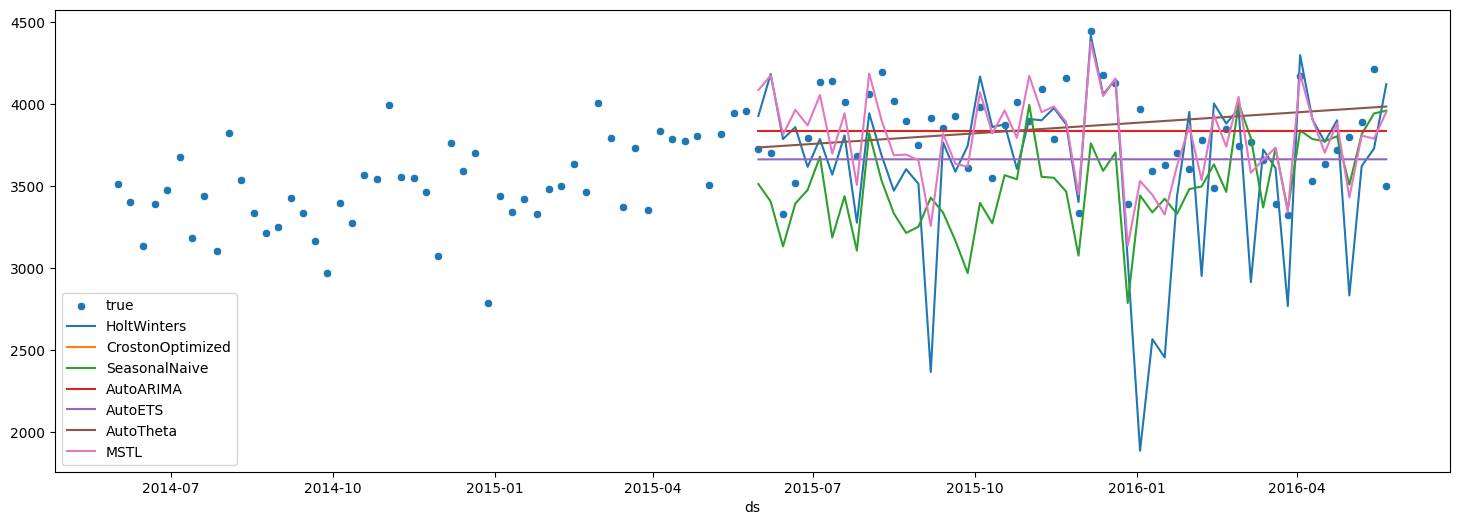

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))

sns.scatterplot(x = data['ds'][-104:], y = data['y'][-104:].values, label = 'true')

for model in model_list:
  model_name = str(model)
  data_plot = pd.Series(forecast[model_name].values, index = test['ds'])
  sns.lineplot(data = data_plot, label = model_name)